<a href="https://colab.research.google.com/github/msartalis/IST-718-Labs/blob/main/Lab_Exercise_1_Matt_Sartalis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [204]:
!pip install python_Levenshtein-0.12.0-cp36-cp36m-win_amd64.whl
!pip install fuzzymatcher

ERROR: python_Levenshtein-0.12.0-cp36-cp36m-win_amd64.whl is not a supported wheel on this platform.


In [205]:
# import packages for analysis and modeling
import pandas as pd  # data frame operations
import fuzzymatcher 
import numpy as np  # arrays and math functions
from scipy.stats import uniform  # for training-and-test split
import statsmodels.api as sm  # statistical models (including regression)
import statsmodels.formula.api as smf  # R-like model specification
import matplotlib.pyplot as plt  # 2D plotting
import json
import seaborn as sns  # PROVIDES TRELLIS AND SMALL MULTIPLE PLOTTING
import tensorflow as tf
import matplotlib.pyplot as plt
from tqdm import tqdm as tqdm
import requests
import lxml.html as lh
import pandas as pd
from pydrive.drive import GoogleDrive
coaches = pd.read_csv("https://raw.githubusercontent.com/2SUBDA/IST_718/master/Coaches9.csv")
print(coaches)

                    School Conference  ... AssistantPay        Buyout
0                Air Force   Mt. West  ...          $0             --
1                    Akron        MAC  ...          $0      $688,500 
2                  Alabama        SEC  ...          $0   $33,600,000 
3    Alabama at Birmingham      C-USA  ...          $0    $3,847,500 
4        Appalachian State   Sun Belt  ...          $0    $2,160,417 
..                     ...        ...  ...          ...           ...
124          West Virginia     Big 12  ...          $0    $7,150,000 
125       Western Kentucky      C-USA  ...          $0    $1,200,000 
126       Western Michigan        MAC  ...          $0      $800,000 
127              Wisconsin    Big Ten  ...          $0    $6,000,000 
128                Wyoming   Mt. West  ...          $0    $8,016,667 

[129 rows x 9 columns]


In [206]:
coaches['SchoolPay'] = coaches['SchoolPay'].astype(str)
coaches['SchoolPay'] = coaches['SchoolPay'].str.replace(',', '')
coaches['SchoolPay'] = coaches['SchoolPay'].str.replace('$', '')
coaches['SchoolPay'] = coaches['SchoolPay'].str.replace('--', '')
coaches['SchoolPay'] = pd.to_numeric(coaches['SchoolPay'],errors='raise')
coaches['SchoolPay'] = coaches['SchoolPay'].fillna(0)

coaches['TotalPay'] = coaches['TotalPay'].str.replace(',', '')
coaches['TotalPay'] = coaches['TotalPay'].str.replace('$', '')
coaches['TotalPay'] = coaches['TotalPay'].str.replace('--', '')
coaches['TotalPay'] = pd.to_numeric(coaches['TotalPay'],errors='raise')
coaches['TotalPay'] = coaches['TotalPay'].fillna(0)

coaches['Bonus'] = coaches['Bonus'].str.replace(',', '')
coaches['Bonus'] = coaches['Bonus'].str.replace('$', '')
coaches['Bonus'] = coaches['Bonus'].str.replace('--', '')
coaches['Bonus'] = pd.to_numeric(coaches['Bonus'],errors='raise')
coaches['Bonus'] = coaches['Bonus'].fillna(0)

coaches['BonusPaid'] = coaches['BonusPaid'].str.replace(',', '')
coaches['BonusPaid'] = coaches['BonusPaid'].str.replace('$', '')
coaches['BonusPaid'] = coaches['BonusPaid'].str.replace('--', '')
coaches['BonusPaid'] = pd.to_numeric(coaches['BonusPaid'],errors='raise')
coaches['BonusPaid'] = coaches['BonusPaid'].fillna(0)

coaches['AssistantPay'] = coaches['AssistantPay'].str.replace(',', '')
coaches['AssistantPay'] = coaches['AssistantPay'].str.replace('$', '')
coaches['AssistantPay'] = coaches['AssistantPay'].str.replace('--', '')
coaches['AssistantPay'] = pd.to_numeric(coaches['AssistantPay'])

coaches['Buyout'] = coaches['Buyout'].str.replace(',', '')
coaches['Buyout'] = coaches['Buyout'].str.replace('$', '')
coaches['Buyout'] = coaches['Buyout'].str.replace('--', '')
coaches['Buyout'] = pd.to_numeric(coaches['Buyout'],errors='raise')
coaches['Buyout'] = coaches['Buyout'].fillna(0)



In [207]:
#Removing Schools with Nan from the data set as it does not have any data

coaches = coaches[coaches['SchoolPay'] > 10] 
coaches.info()



<class 'pandas.core.frame.DataFrame'>
Int64Index: 125 entries, 0 to 128
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   School        125 non-null    object 
 1   Conference    125 non-null    object 
 2   Coach         125 non-null    object 
 3   SchoolPay     125 non-null    float64
 4   TotalPay      125 non-null    float64
 5   Bonus         125 non-null    float64
 6   BonusPaid     125 non-null    float64
 7   AssistantPay  125 non-null    int64  
 8   Buyout        125 non-null    float64
dtypes: float64(5), int64(1), object(3)
memory usage: 9.8+ KB


In [208]:
stadiums = pd.read_csv('/content/drive/My Drive/Colab Notebooks/stadiums.csv')

stadiums['Capacity'] = stadiums['Capacity'].str.replace(',', '')
stadiums['Capacity'] = pd.to_numeric(stadiums['Capacity'], errors='raise')

stadiums['Conference']=stadiums['Conference'].replace({'Mountain West': 'Mt. West'})
stadiums['Conference']=stadiums['Conference'].replace({'Independent': 'Ind.'})

stadiums.head()




,Stadium,College,Conference,Capacity,Opened
0,Falcon Stadium,Air Force,Mt. West,52237.0,1962.0
1,InfoCision Stadium,Akron,MAC,30000.0,2009.0
2,Bryant Denny Stadium,Alabama,SEC,101821.0,1929.0
3,Kidd Brewer Stadium,Appalachain State,Sun Belt,24150.0,1962.0
4,Arizona Stadium,Arizona,Pac 12,56037.0,1928.0


# New Section

In [244]:
      
WL = pd.read_csv('/content/drive/My Drive/Colab Notebooks/WL.csv',encoding= 'unicode_escape')

WL.head()



,Rank,School,Won,Lost,Tied,Pct.,Years,Total Games,Conference
0,1,Ohio State,931,327,53,0.730,130,1311,Big Ten
1,2,Alabama,929,331,43,0.729,125,1303,SEC
2,3,Notre Dame,918,328,42,0.729,130,1288,Independent
3,4,Boise State,465,172,2,0.729,52,639,Mountain West
4,5,Michigan,964,350,36,0.727,140,1350,Big Ten
...,...,...,...,...,...,...,...,...,...
125,126,UNLV 11,236,364,4,0.394,52,604,Mountain West
126,127,Kent State,353,570,28,0.386,97,951,MAC
127,128,FIU,79,143,0,0.356,18,222,C-USA
128,129,Charlotte,34,62,0,0.354,9,96,C-USA


In [210]:
Gradrates = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Gradrates.csv')

Gradrates['Conference']=Gradrates['Conference'].replace({'American Ahtletic Conference': 'AAC'})
Gradrates['Conference']=Gradrates['Conference'].replace({'Atlantic Coast Conference': 'ACC'})
Gradrates['Conference']=Gradrates['Conference'].replace({'Southeastern Conference': 'SEC'})
Gradrates['Conference']=Gradrates['Conference'].replace({'Big 12 Conference': 'Big 12'})
Gradrates['Conference']=Gradrates['Conference'].replace({'Mountain West Conference': 'Mt. West'})
Gradrates['Conference']=Gradrates['Conference'].replace({'Sun Belt Conference': 'Sun Belt'})
Gradrates['Conference']=Gradrates['Conference'].replace({'Conference USA': 'C-USA'})
Gradrates['Conference']=Gradrates['Conference'].replace({'Big Ten Conference': 'Big Ten'})
Gradrates['Conference']=Gradrates['Conference'].replace({'Independent': 'Ind.'})
Gradrates['Conference']=Gradrates['Conference'].replace({'Mid-American Conference': 'MAC'})
Gradrates['Conference']=Gradrates['Conference'].replace({'Pac-12 Conference': 'Pac-12'})


Gradrates.head()



,Cohort Year,School,Conference,Sport,State,GSR,FGR
0,2012,Abilene Christian University,Southland Conference,Football,TX,70,47.0
1,2012,University of Akron,MAC,Football,OH,75,61.0
2,2012,Alabama A&M University,Southwestern Athletic Conf.,Football,AL,59,49.0
3,2012,Alabama State University,Southwestern Athletic Conf.,Football,AL,58,39.0
4,2012,University of Alabama,SEC,Football,AL,85,65.0


In [211]:
Revenue1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Revenue.csv')



Revenue1['REVENUES'] = Revenue1['REVENUES'].str.replace(',', '')
Revenue1['REVENUES'] = pd.to_numeric(Revenue1['REVENUES'], errors='raise')


Revenue1=Revenue1.rename(columns = {"SCHOOL":"School"})
Revenue1=Revenue1.rename(columns = {"Conference":"Conf"})
Revenue1=Revenue1.rename(columns = {"REVENUES":"Total Revenue"})

del Revenue1['2018 VALUE']
del Revenue1['RANK']


Revenue1.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 114 entries, 0 to 113
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   School         114 non-null    object
 1   Conf           114 non-null    object
 2   Total Revenue  114 non-null    int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ KB


In [212]:
from pandas.io.html import read_html
page= 'https://sports.usatoday.com/ncaa/finances'
Revenue = pd.read_html(page, index_col=0, attrs ={"class":"datatable datatable-finances fixed-column"}, header=0)[0]
Revenue.drop(Revenue.tail(1).index,inplace=True)



Revenue['Total Revenue'] = Revenue['Total Revenue'].str.replace(',', '')
Revenue['Total Revenue'] = Revenue['Total Revenue'].str.replace('$', '')
Revenue['Total Revenue'] = Revenue['Total Revenue'].str.replace('--', '')
Revenue['Total Revenue'] = pd.to_numeric(Revenue['Total Revenue'], errors='raise')

Revenue['Total Expenses'] = Revenue['Total Expenses'].str.replace(',', '')
Revenue['Total Expenses'] = Revenue['Total Expenses'].str.replace('$', '')
Revenue['Total Expenses'] = Revenue['Total Expenses'].str.replace('--', '')
Revenue['Total Expenses'] = pd.to_numeric(Revenue['Total Expenses'],errors='raise')

del Revenue['Total Allocated']
del Revenue['% Allocated']


Rev=Revenue.append(Revenue1)

Rev.drop_duplicates(subset=['School'],keep='first',inplace=True)


Rev.info()




<class 'pandas.core.frame.DataFrame'>
Index: 253 entries, 1 to 113
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   School          253 non-null    object 
 1   Conf            253 non-null    object 
 2   Total Revenue   253 non-null    int64  
 3   Total Expenses  227 non-null    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 9.9+ KB


In [213]:
left_on = ["School", "Conference"]
right_on = ["School", "Conf"]

dfjoined = fuzzymatcher.fuzzy_left_join(coaches,Rev, left_on, right_on) #Merge on School and Conference
dfjoined.sort_values(by='best_match_score', ascending = False)

  
dfjoined = dfjoined[dfjoined['best_match_score'] > 0.10]



dfjoined.rename(columns = {"School_left":"School"})
dfjoined.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 117 entries, 0 to 179
Data columns (total 16 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   best_match_score  117 non-null    float64
 1   __id_left         117 non-null    object 
 2   __id_right        117 non-null    object 
 3   School_left       117 non-null    object 
 4   Conference        117 non-null    object 
 5   Coach             117 non-null    object 
 6   SchoolPay         117 non-null    float64
 7   TotalPay          117 non-null    float64
 8   Bonus             117 non-null    float64
 9   BonusPaid         117 non-null    float64
 10  AssistantPay      117 non-null    int64  
 11  Buyout            117 non-null    float64
 12  School_right      117 non-null    object 
 13  Conf              117 non-null    object 
 14  Total Revenue     117 non-null    float64
 15  Total Expenses    106 non-null    float64
dtypes: float64(8), int64(1), object(7)
memory us

In [214]:
dfjoined=dfjoined.rename(columns = {"School_left":"School"})
dfjoined.head()

,best_match_score,__id_left,__id_right,School,Conference,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,School_right,Conf,Total Revenue,Total Expenses
0,0.591582,0_left,56_right,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,0.0,0,0.0,Air Force,Mt. West,60009782.0,54192115.0
1,0.273403,1_left,83_right,Akron,MAC,Terry Bowden,411000.0,412500.0,225000.0,50000.0,0,688500.0,Akron,MAC,37194485.0,37275978.0
2,0.224893,2_left,6_right,Alabama,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,0,33600000.0,Alabama,SEC,164090889.0,185317681.0
3,0.674796,3_left,85_right,Alabama at Birmingham,C-USA,Bill Clark,900000.0,900000.0,950000.0,165471.0,0,3847500.0,Alabama at Birmingham,C-USA,36494381.0,35697117.0
4,0.430059,4_left,80_right,Appalachian State,Sun Belt,Scott Satterfield,712500.0,712500.0,295000.0,145000.0,0,2160417.0,Appalachian State,Sun Belt,37996512.0,37773447.0


In [215]:
del dfjoined['best_match_score']
del dfjoined['__id_left']
del dfjoined['__id_right']





In [216]:
dfjoined.rename(columns = {"School_left":"School"})

left_on = ["School", "Conference"]
right_on = ["School", "Conference"]

dfjoined2 = fuzzymatcher.fuzzy_left_join(dfjoined,WL, left_on, right_on) #Merge on School and Conference

dfjoined2 = dfjoined2[dfjoined2['best_match_score'] > 0.10 ]
dfjoined2

del dfjoined2['best_match_score']
del dfjoined2['__id_left']
del dfjoined2['__id_right']

In [217]:
dfjoined2=dfjoined2.rename(columns = {"School_left":"School"})
dfjoined2=dfjoined2.rename(columns = {"Conference_left":"Conference"})
left_on = ["School", "Conference"]
right_on = ["School", "Conference"]

dfjoined3 = fuzzymatcher.fuzzy_left_join(dfjoined2,Gradrates, left_on, right_on) #Merge on School and Conference
dfjoined3 = dfjoined3[dfjoined3['best_match_score'] > 0.10 ]
dfjoined3

,best_match_score,__id_left,__id_right,School_left,Conference_left,Coach,SchoolPay,TotalPay,Bonus,BonusPaid,AssistantPay,Buyout,School_right,School_right,School_right,School_right,School_right,School_right,School_right,School_right,School_right,School_right,Conf,Total Revenue,Total Expenses,Rank,School_right,School_right,School_right,School_right,School_right,School_right,School_right,School_right,School_right,School_right,Won,Lost,Tied,Pct.,Years,Total Games,Conference_right,Conference_right,Cohort Year,School_right,School_right,School_right,School_right,School_right,Conference_right,Conference_right,Sport,State,GSR,FGR
0,0.427329,0_left,218_right,Air Force,Mt. West,Troy Calhoun,885000.0,885000.0,247000.0,0.0,0,0.0,Air Force,Air Force,Air Force,Air Force,U.S. Air Force Academy,Air Force,Air Force,Air Force,Air Force,U.S. Air Force Academy,Mt. West,60009782.0,54192115.0,64.0,Air Force,Air Force,Air Force,Air Force,U.S. Air Force Academy,Air Force,Air Force,Air Force,Air Force,U.S. Air Force Academy,404.0,332.0,13.0,0.548,64.0,749.0,Mountain West,Mt. West,2012,Air Force,Air Force,Air Force,Air Force,U.S. Air Force Academy,Mountain West,Mt. West,Football,CO,80,NaN
1,0.259051,1_left,1_right,Akron,MAC,Terry Bowden,411000.0,412500.0,225000.0,50000.0,0,688500.0,Akron,Akron,Akron,Akron,University of Akron,Akron,Akron,Akron,Akron,University of Akron,MAC,37194485.0,37275978.0,101.0,Akron,Akron,Akron,Akron,University of Akron,Akron,Akron,Akron,Akron,University of Akron,524.0,563.0,36.0,0.483,119.0,1123.0,MAC,MAC,2012,Akron,Akron,Akron,Akron,University of Akron,MAC,MAC,Football,OH,75,61.0
2,0.193203,2_left,4_right,Alabama,SEC,Nick Saban,8307000.0,8307000.0,1100000.0,500000.0,0,33600000.0,Alabama,Alabama,Alabama,Alabama,University of Alabama,Alabama,Alabama,Alabama,Alabama,University of Alabama,SEC,164090889.0,185317681.0,2.0,Alabama,Alabama,Alabama,Alabama,University of Alabama,Alabama,Alabama,Alabama,Alabama,University of Alabama,929.0,331.0,43.0,0.729,125.0,1303.0,SEC,SEC,2012,Alabama,Alabama,Alabama,Alabama,University of Alabama,SEC,SEC,Football,AL,85,65.0
3,0.492675,3_left,8_right,Appalachian State,Sun Belt,Scott Satterfield,712500.0,712500.0,295000.0,145000.0,0,2160417.0,Appalachian State,Appalachian State,Appalachian State,Appalachian State,Appalachian State University,Appalachian State,Appalachian State,Appalachian State,Appalachian State,Appalachian State University,Sun Belt,37996512.0,37773447.0,15.0,Appalachian State,Appalachian State,Appalachian State,Appalachian State,Appalachian State University,Appalachian State,Appalachian State,Appalachian State,Appalachian State,Appalachian State University,639.0,339.0,29.0,0.649,90.0,1007.0,Sun Belt,Sun Belt,2012,Appalachian State,Appalachian State,Appalachian State,Appalachian State,Appalachian State University,Sun Belt,Sun Belt,Football,NC,75,67.0
4,0.252369,4_left,10_right,Arizona,Pac-12,Kevin Sumlin,1600000.0,2000000.0,2025000.0,0.0,0,10000000.0,Arizona,Arizona,Arizona,Arizona,University of Arizona,Arizona,Arizona,Arizona,Arizona,University of Arizona,Pac-12,105091389.0,100565835.0,53.0,Arizona,Arizona,Arizona,Arizona,University of Arizona,Arizona,Arizona,Arizona,Arizona,University of Arizona,617.0,478.0,33.0,0.562,116.0,1128.0,Pac-12,Pac-12,2012,Arizona,Arizona,Arizona,Arizona,University of Arizona,Pac-12,Pac-12,Football,AZ,76,58.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,0.624423,102_left,234_right,West Virginia,Big 12,Dana Holgorsen,3605000.0,3617500.0,1000000.0,90000.0,0,7150000.0,West Virginia,West Virginia,West Virginia,West Virginia,West Virginia University,West Virginia,West Virginia,West Virginia,West Virginia,West Virginia University,Big 12,102680928.0,98249890.0,27.0,West Virginia,West Virginia,West Virginia,West Virginia,West Virginia University,West Virginia,West Virginia,West Virgi

In [218]:
del dfjoined3['Conference_right']
del dfjoined3['School_right']

dfjoined3=dfjoined3.rename(columns = {"School_left":"School"})
dfjoined3=dfjoined3.rename(columns = {"Conference_left":"Conference"})

dfjoined3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 170
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   best_match_score  100 non-null    float64
 1   __id_left         100 non-null    object 
 2   __id_right        100 non-null    object 
 3   School            100 non-null    object 
 4   Conference        100 non-null    object 
 5   Coach             100 non-null    object 
 6   SchoolPay         100 non-null    float64
 7   TotalPay          100 non-null    float64
 8   Bonus             100 non-null    float64
 9   BonusPaid         100 non-null    float64
 10  AssistantPay      100 non-null    int64  
 11  Buyout            100 non-null    float64
 12  Conf              100 non-null    object 
 13  Total Revenue     100 non-null    float64
 14  Total Expenses    89 non-null     float64
 15  Rank              100 non-null    float64
 16  Won               100 non-null    float64
 1

In [219]:
del dfjoined3['best_match_score']
del dfjoined3['__id_left']
del dfjoined3['__id_right']
dfjoined3.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 170
Data columns (total 24 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   School          100 non-null    object 
 1   Conference      100 non-null    object 
 2   Coach           100 non-null    object 
 3   SchoolPay       100 non-null    float64
 4   TotalPay        100 non-null    float64
 5   Bonus           100 non-null    float64
 6   BonusPaid       100 non-null    float64
 7   AssistantPay    100 non-null    int64  
 8   Buyout          100 non-null    float64
 9   Conf            100 non-null    object 
 10  Total Revenue   100 non-null    float64
 11  Total Expenses  89 non-null     float64
 12  Rank            100 non-null    float64
 13  Won             100 non-null    float64
 14  Lost            100 non-null    float64
 15  Tied            100 non-null    float64
 16  Pct.            100 non-null    float64
 17  Years           100 non-null    flo

In [259]:
right_on = ["College", "Conference"]
CoachData = fuzzymatcher.fuzzy_left_join(dfjoined3,stadiums, left_on, right_on) #Merge on School and Conference

del CoachData['best_match_score']
del CoachData['__id_left']
del CoachData['__id_right']
del CoachData['Conference_right']

CoachData=CoachData.rename(columns = {"Conference_left":"Conference"})
CoachData=CoachData.rename(columns = {"Total Revenue":"Total_Revenue"})
CoachData=CoachData.rename(columns = {"Total Expenses":"Total_Expenses"})
CoachData=CoachData.rename(columns = {"Pct.":"Pct"})

CoachData['Buyout'] = CoachData['Buyout'].fillna(0)

CoachData['Rank']

CoachData.info()
#Conf_Variables=pd.get_dummies(CoachData['Conference'])
#CoachData['Conference DVar']=Conf_Variables


<class 'pandas.core.frame.DataFrame'>
Int64Index: 100 entries, 0 to 142
Data columns (total 28 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   School          100 non-null    object 
 1   Conference      100 non-null    object 
 2   Coach           100 non-null    object 
 3   SchoolPay       100 non-null    float64
 4   TotalPay        100 non-null    float64
 5   Bonus           100 non-null    float64
 6   BonusPaid       100 non-null    float64
 7   AssistantPay    100 non-null    int64  
 8   Buyout          100 non-null    float64
 9   Conf            100 non-null    object 
 10  Total_Revenue   100 non-null    float64
 11  Total_Expenses  89 non-null     float64
 12  Rank            100 non-null    float64
 13  Won             100 non-null    float64
 14  Lost            100 non-null    float64
 15  Tied            100 non-null    float64
 16  Pct             100 non-null    float64
 17  Years           100 non-null    flo

Text(0, 0.5, 'Capacity')

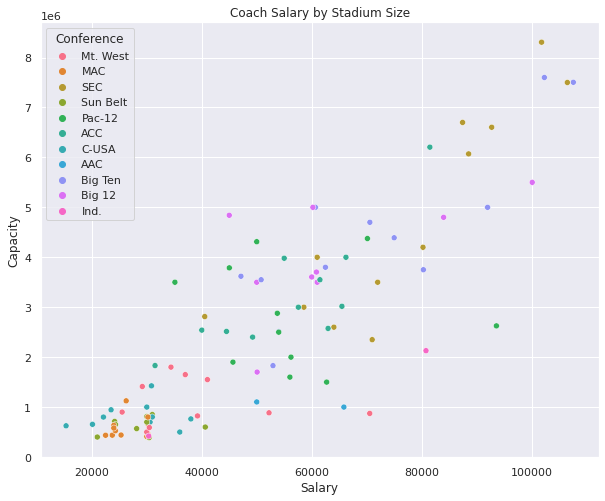

In [240]:
#Visualizations 

sns.scatterplot(data=CoachData, x="Capacity", y="SchoolPay", hue="Conference")
sns.set(rc = {'figure.figsize':(10,8)})
plt.title('Coach Salary by Stadium Size')  
plt.xlabel('Salary')  
plt.ylabel('Capacity')


In [254]:
#Median Salary per Conference

from numpy import median
sns.set_theme(style="whitegrid")
ax = sns.barplot(x="Pct>.5", y="SchoolPay", data=CoachData, estimator=median)
plt.title('Median Salary Per Conference')
sns.set(rc = {'figure.figsize':(10,8)})  

ValueError: ignored

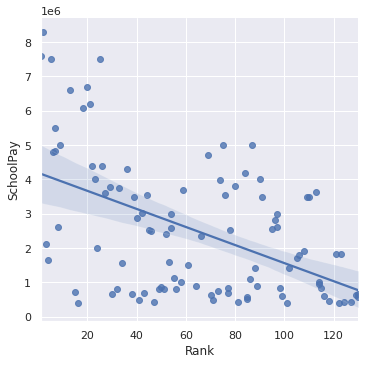

In [250]:
sns.lmplot(x="Rank", y="SchoolPay", data=CoachData)

Text(0, 0.5, 'Salary')

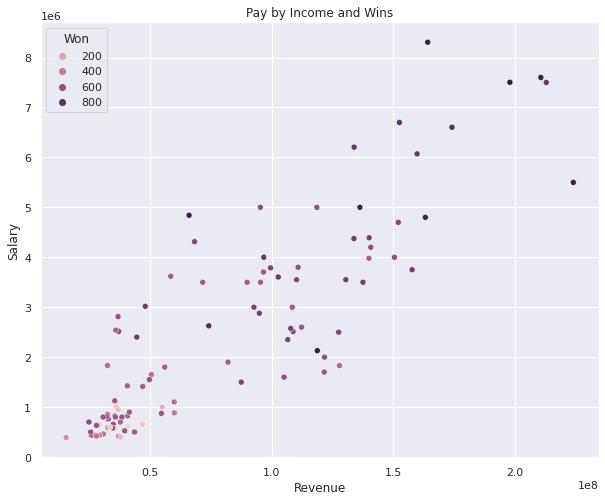

In [248]:
sns.scatterplot(data=CoachData, x="Total_Revenue", y="SchoolPay", hue="Won")
sns.set(rc = {'figure.figsize':(10,8)})
plt.title('Pay by Income and Wins')  
plt.xlabel('Revenue')  
plt.ylabel('Salary')

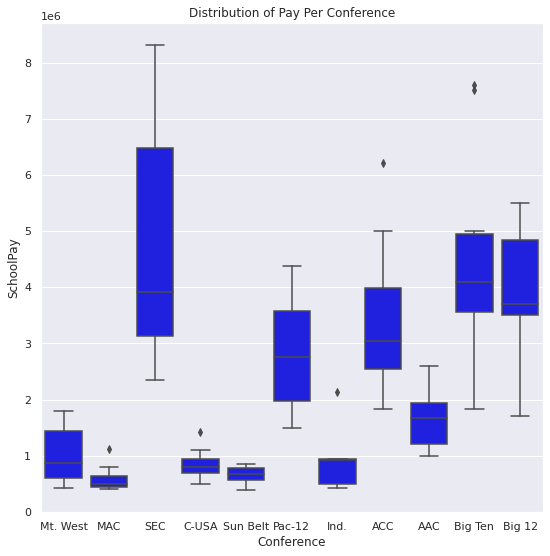

In [239]:

sns.boxplot(x="Conference", y="SchoolPay", data=coaches, color = "blue");

plt.title('Distribution of Pay Per Conference')
sns.set(rc = {'figure.figsize':(10,8)})
plt.show()





In [255]:
# MOdels 

model_1 = str('SchoolPay ~ Conference=="Big Ten"+Capacity+GSR+Total_Revenue+Pct+Rank+Won+Lost+Tied')
model_1_fit = smf.ols(model_1, data = CoachData).fit()
print(model_1_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              SchoolPay   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     38.41
Date:                Sun, 25 Jul 2021   Prob (F-statistic):           4.26e-27
Time:                        17:21:46   Log-Likelihood:                -1512.4
No. Observations:                 100   AIC:                             3045.
Df Residuals:                      90   BIC:                             3071.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 

In [256]:


model_2 = str('SchoolPay ~ Capacity+GSR+Bonus+Total_Revenue+Pct+Rank+Won+Lost+Tied')
model_2_fit = smf.ols(model_2, data = CoachData).fit()
print(model_2_fit.summary())


                            OLS Regression Results                            
Dep. Variable:              SchoolPay   R-squared:                       0.797
Model:                            OLS   Adj. R-squared:                  0.777
Method:                 Least Squares   F-statistic:                     39.33
Date:                Sun, 25 Jul 2021   Prob (F-statistic):           1.86e-27
Time:                        17:22:00   Log-Likelihood:                -1511.5
No. Observations:                 100   AIC:                             3043.
Df Residuals:                      90   BIC:                             3069.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      5.014e+05   3.07e+06      0.163

In [258]:
model_3 = str('SchoolPay ~ Capacity+GSR')
model_3_fit = smf.ols(model_3, data = CoachData).fit()
print(model_3_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              SchoolPay   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.720
Method:                 Least Squares   F-statistic:                     128.1
Date:                Sun, 25 Jul 2021   Prob (F-statistic):           6.07e-28
Time:                        17:22:20   Log-Likelihood:                -1526.6
No. Observations:                 100   AIC:                             3059.
Df Residuals:                      97   BIC:                             3067.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept  -2.015e+06    9.5e+05     -2.121      0.0

In [ ]:
model_3 = str('SchoolPay ~ GSR+FGR')
model_3_fit = smf.ols(model_3, data = CoachData).fit()
print(model_3_fit.summary())

In [260]:
#Big Ten Analysis

model_4 = str('SchoolPay ~ Conference=="Big Ten"+Capacity+GSR+Total_Revenue+Pct+Rank+Won+Lost+Tied')
model_4_fit = smf.ols(model_4, data = CoachData).fit()
print(model_4_fit.summary())

                            OLS Regression Results                            
Dep. Variable:              SchoolPay   R-squared:                       0.793
Model:                            OLS   Adj. R-squared:                  0.773
Method:                 Least Squares   F-statistic:                     38.41
Date:                Sun, 25 Jul 2021   Prob (F-statistic):           4.26e-27
Time:                        17:41:50   Log-Likelihood:                -1512.4
No. Observations:                 100   AIC:                             3045.
Df Residuals:                      90   BIC:                             3071.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                                      coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept 